# Multiple Linear Regression with sklearn

In this notebook we will make basic predictions of carprice

# Getting Started

In [1]:
# Import Libs
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

In [2]:
# Read Data
raw_data = pd.read_csv('../proprietary_data/cardata.csv')
raw_data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


# Preprocessing

#### Handle missing values

In [3]:
# analyse numerical data
data = raw_data.drop(['Model'],axis=1)
data.isnull().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
dtype: int64

In [4]:
# to simplify we just drop those rows
data = data.dropna(axis=0)
data.isnull().sum()

Brand           0
Price           0
Body            0
Mileage         0
EngineV         0
Engine Type     0
Registration    0
Year            0
dtype: int64

#### Explore "Price"

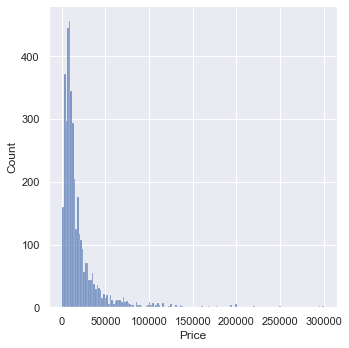

In [5]:
# check skewness using histogram
sns.displot(data['Price'])

Looks like we can easily remove 1pct quartile

In [6]:
# get 1pct quartile
q = data['Price'].quantile(0.99)
data = data[data['Price']<q]

#### Explore "EngineV"

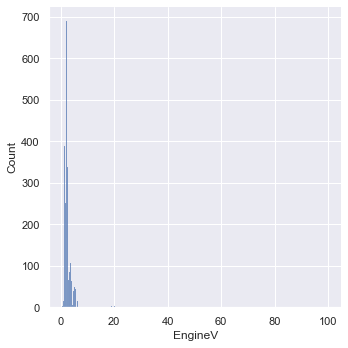

In [7]:
sns.displot(data['EngineV'])

Looks like we have some crazy outliers with values as 99.
We can cap the Engine volume to 6.5

In [8]:
data = data[data['EngineV']<6.5]

#### Explore "Year"

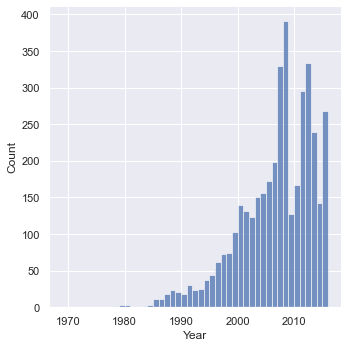

In [9]:
sns.displot(data['Year'])

Looks like it is safe to remove extremely old cars. Lets remove the lower 1pct fractile

In [10]:
# I'll simply remove them
q = data['Year'].quantile(0.01)
data = data[data['Year']>q]

#### Explore cleaned Dataset

In [11]:
data = data.reset_index(drop=True)
data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,3905,3905.000000,3905,3905.000000,3905.000000,3905,3905,3905.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,861,NaN,1482,NaN,NaN,1835,3540,NaN
mean,NaN,18100.297083,NaN,164.107298,2.449795,NaN,NaN,2006.620487
std,NaN,19056.178291,NaN,102.377608,0.947793,NaN,NaN,6.173623
min,NaN,800.000000,NaN,0.000000,0.600000,NaN,NaN,1988.000000
25%,NaN,7150.000000,NaN,92.000000,1.800000,NaN,NaN,2003.000000
50%,NaN,11500.000000,NaN,159.000000,2.200000,NaN,NaN,2008.000000
75%,NaN,21500.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000


## Checking the OLS assumptions

To safely use features for linear regression they need to adhere to the assumptions, including
* Following a normal distribution
* Multicollinearity

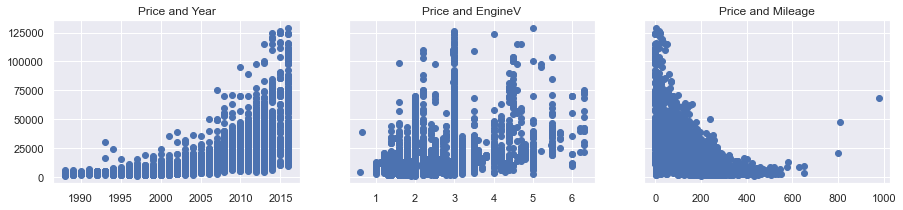

<AxesSubplot:xlabel='Price', ylabel='Count'>

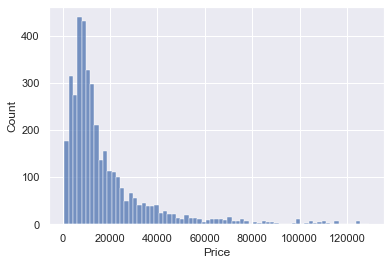

In [12]:
# Plot Year, EngineV and Mileage against Price
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3))
ax1.scatter(data['Year'], data['Price'])
ax1.set_title('Price and Year')
ax2.scatter(data['EngineV'], data['Price'])
ax2.set_title('Price and EngineV')
ax3.scatter(data['Mileage'], data['Price'])
ax3.set_title('Price and Mileage')
plt.show()

# Plot Price
sns.histplot(data['Price'])

Based on above charts, it is clear that Price is exponential (not linear). We should apply Log Transformation to relax it

<AxesSubplot:xlabel='Price', ylabel='Count'>

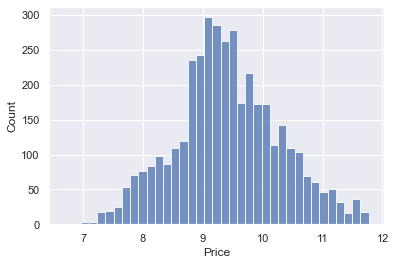

In [13]:
data['Price'] = np.log(data['Price'])
sns.histplot(data['Price'])

### Multicollinearity

In [14]:
data.columns.values

array(['Brand', 'Price', 'Body', 'Mileage', 'EngineV', 'Engine Type',
       'Registration', 'Year'], dtype=object)

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# check the variance inflation factor
variables = data[['Mileage','Year','EngineV']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif

,VIF,Features
0,3.546054,Mileage
1,10.140993,Year
2,7.680951,EngineV


As Year has a significant variance inflation factor we decide to remove it

In [16]:
data = data.drop(['Year'],axis=1)

#### Get dummies for categorical data
This is required for including categorical features in linear regression

In [17]:
data = pd.get_dummies(data, drop_first=True)
data.head()

,Price,Mileage,EngineV,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,8.342840,277,2.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,8.974618,427,2.9,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,9.495519,358,5.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,10.043249,240,4.2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,9.814656,120,2.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


### Rearrange a bit

In [18]:
# data.columns.values
cols = ['Price', 'Mileage', 'EngineV', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes']

data = data[cols]

# Linear Regression Model

#### Declare the inputs and the targets

In [19]:
targets = data['Price']
inputs = data.drop(['Price'],axis=1)

#### Scale the data

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(inputs)
inputs_scaled = scaler.transform(inputs)

#### Train Test Split

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365)

#### Create the regression

In [22]:
reg = LinearRegression()
reg.fit(x_train,y_train)
y_hat = reg.predict(x_train)

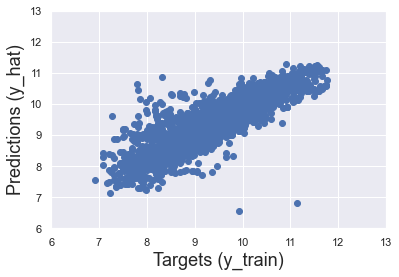

In [23]:
plt.scatter(y_train, y_hat)
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

The above charts shows that the model is capable of predicting the correct values

Text(0.5, 1.0, 'Residuals PDF')

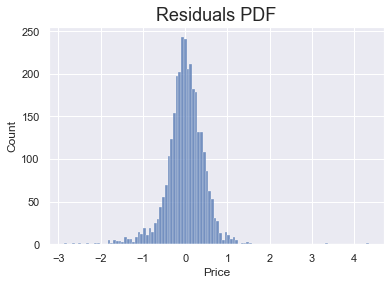

In [24]:
# plot residuals
sns.histplot(y_train - y_hat)
plt.title("Residuals PDF", size=18)

As the residuals are normally distributed, we can be quite satisfied with the result

In [25]:
reg.score(x_train,y_train)

0.7339089649912189

The R-squared value is .73, which is also good (score from 0 to 1, where 1 means that perfect linear relationship)

### Finding the weights and bias

In [26]:
# Bias
print('Bias:', reg.intercept_)

# Weights
print('Weights:')
reg_summary = pd.DataFrame(inputs.columns.values, columns=['Feature'])
reg_summary['Weights'] = reg.coef_
reg_summary

Bias: 9.410666694192361
Weights:


,Feature,Weights
0,Mileage,-0.446884
1,EngineV,0.214707
2,Brand_BMW,0.014820
3,Brand_Mercedes-Benz,0.015800
4,Brand_Mitsubishi,-0.124224
5,Brand_Renault,-0.181272
6,Brand_Toyota,-0.051602
7,Brand_Volkswagen,-0.084373
8,Body_hatch,-0.135760
9,Body_other,-0.104218


## Testing

In [27]:
# predict on test data
y_hat_test = reg.predict(x_test)
y_test = y_test.reset_index(drop=True)

In [28]:
# setup table for comparison
df_pf = pd.DataFrame()
df_pf['Prediction'] = np.exp(y_hat_test)
df_pf['Target'] = np.exp(y_test)
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)

In [29]:
df_pf

,Prediction,Target,Residual,Difference%
0,4947.898561,8200.0,3252.101439,39.659774
1,3382.870468,2350.0,-1032.870468,43.951935
2,52733.700690,36500.0,-16233.700690,44.475892
3,36283.210380,28500.0,-7783.210380,27.309510
4,7054.096593,6300.0,-754.096593,11.969787
...,...,...,...,...
776,11023.101982,7800.0,-3223.101982,41.321820
777,10184.873706,20500.0,10315.126294,50.317689
778,66843.120543,53500.0,-13343.120543,24.940412
779,32440.836282,36900.0,4459.163718,12.084455


In [30]:
# explore predictions individually
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_pf.sort_values(by=['Difference%'])

,Prediction,Target,Residual,Difference%
259,17504.61,17500.00,-4.61,0.03
33,14889.15,14900.00,10.85,0.07
223,43798.95,43900.00,101.05,0.23
630,23943.85,24000.00,56.15,0.23
385,19752.29,19800.00,47.71,0.24
24,8975.19,8999.00,23.81,0.26
26,40119.31,39999.00,-120.31,0.30
370,12703.16,12650.00,-53.16,0.42
377,6028.19,6000.00,-28.19,0.47
135,19802.80,19900.00,97.20,0.49
